In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import pickle
pd.set_option('display.expand_frame_repr', False)

# Load and explore the Dataset
- The dataset has over 1.5 million hotel reviews with a rating scaled from 0 to 5

In [124]:
file = "Hotels_by_Reviews.gz"
df = pd.read_csv(file, index_col=0, dtype='str')
print(df)

                                    Hotel Rating                                               Text
0        Gateway_Motor_Inn_Boutique_Hotel    5.0  The motel is surrounded with beautiful white r...
1        Gateway_Motor_Inn_Boutique_Hotel    5.0  Nice and quiet  No one in the reception when I...
2        Gateway_Motor_Inn_Boutique_Hotel    3.0  Uninviting  Pulled into the carpark, it was co...
3        Gateway_Motor_Inn_Boutique_Hotel    5.0  Fresh, clean surroundings and comfortable beds...
4        Gateway_Motor_Inn_Boutique_Hotel    4.0  dark interior  reception was off putting becau...
...                                   ...    ...                                                ...
1534555        Hong Kong Disneyland Hotel    5.0  This is our first Disneyland Hotel stay and my...
1534556        Hong Kong Disneyland Hotel    5.0  Stayed at Disneyland Hotel on the way back fro...
1534557        Hong Kong Disneyland Hotel    5.0  Initially booked 2 rooms @ Hollywood hotel. Di...


In [125]:
set(df.Rating)

{'0.0', '1.0', '2.0', '3.0', '4.0', '5.0'}

### What is the distribution of ratings ?

In [127]:
ratings=[]
for rating, df_rating in df.groupby('Rating'):
    ratings.append([int(float(rating)), df_rating.Rating.count()])

In [203]:
df_ratings = pd.DataFrame(ratings, columns=['rating','num_reviews'], dtype='int')
df_ratings

,rating,num_reviews
0,0,5
1,1,116021
2,2,128432
3,3,229764
4,4,479658
5,5,580680


In [204]:
df_ratings.dtypes

rating         int32
num_reviews    int32
dtype: object

In [205]:
import plotly.express as px
fig = px.bar(df_ratings, x='rating', y='num_reviews')
fig.show()

- Rating 5 is the most common
- Fewer ratings below 3

# Topic modeling using Latent Dirichlet Allocation

In [37]:
from gensim.parsing import preprocessing
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
import spacy
import re
import toolz as ct

In [38]:
function_words_single = ["the", "of", "and", "to", "a", "in", "i", "he", "that", "was", "it", "his", "you", "with", "as", "for", "had", "is", "her", "not", "but", "at", "on", "she", "be", "have", "by", "which", "him", "they", "this", "from", "all", "were", "my", "we", "one", "so", "said", "me", "there", "or", "an", "are", "no", "would", "their", "if", "been", "when", "do", "who", "what", "them", "will", "out", "up", "then", "more", "could", "into", "man", "now", "some", "your", "very", "did", "has", "about", "time", "can", "little", "than", "only", "upon", "its", "any", "other", "see", "our", "before", "two", "know", "over", "after", "down", "made", "should", "these", "must", "such", "much", "us", "old", "how", "come", "here", "never", "may", "first", "where", "go", "s", "came", "men", "way", "back", "himself", "own", "again", "say", "day", "long", "even", "too", "think", "might", "most", "through", "those", "am", "just", "make", "while", "went", "away", "still", "every", "without", "many", "being", "take", "last", "shall", "yet", "though", "nothing", "get", "once", "under", "same", "off", "another", "let", "tell", "why", "left", "ever", "saw", "look", "seemed", "against", "always", "going", "few", "got", "something", "between", "sir", "thing", "also", "because", "yes", "each", "oh", "quite", "both", "almost", "soon", "however", "having", "t", "whom", "does", "among", "perhaps", "until", "began", "rather", "herself", "next", "since", "anything", "myself", "nor", "indeed", "whose", "thus", "along", "others", "till", "near", "certain", "behind", "during", "alone", "already", "above", "often", "really", "within", "used", "use", "itself", "whether", "around", "second", "across", "either", "towards", "became", "therefore", "able", "sometimes", "later", "else", "seems", "ten", "thousand", "don", "certainly", "ought", "beyond", "toward", "nearly", "although", "past", "seem", "mr", "mrs", "dr", "thou", "except", "none", "probably", "neither", "saying", "ago", "ye", "yourself", "getting", "below", "quickly", "beside", "besides", "especially", "thy", "thee", "d", "unless", "three", "four", "five", "six", "seven", "eight", "nine", "hundred", "million", "billion", "third", "fourth", "fifth", "sixth", "seventh", "eighth", "ninth", "tenth", "amp", "m", "re", "u", "via", "ve", "ll", "th", "lol", "pm", "things", "w", "didn", "doing", "doesn", "r", "gt", "n", "st", "lot", "y", "im", "k", "isn", "ur", "hey", "yeah", "using", "vs", "dont", "ok", "v", "goes", "gone", "lmao", "happen", "wasn", "gotta", "nd", "okay", "aren", "wouldn", "couldn", "cannot", "omg", "non", "inside", "iv", "de", "anymore", "happening", "including", "shouldn", "yours",]
print(len(function_words_single))

322


In [39]:
phrases = None

#This is a placeholder for spacy's tagger
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 9999999999999

def clean(line, tag = False):

        #Remove links, hashtags, at-mentions, mark-up, and "RT"
        line = re.sub(r"http\S+", "", line)
        line = re.sub(r"@\S+", "", line)
        line = re.sub(r"#\S+", "", line)
        line = re.sub("<[^>]*>", "", line)
        line = line.replace(" RT", "").replace("RT ", "")

        #Remove punctuation and extra spaces
        line = ct.pipe(line, 
                preprocessing.strip_tags, 
                preprocessing.strip_punctuation, 
                preprocessing.strip_numeric, 
                preprocessing.strip_non_alphanum, 
                preprocessing.strip_multiple_whitespaces)

        #Strip and lowercase
        line = line.lower().strip().lstrip().split()

        #If we've used PMI to find phrases, get those phrases now
        if phrases != None:
            line = list(phrases[line])

        #If we want Part-of-Speech tagging, do that now
        if tag == True:
            line = nlp(" ".join(line))
            line = [w.text + "_" + w.pos_ for w in line]

        return line


def read_clean(df, tag = False, column = "Text"):
    return [clean(str(x), tag = tag) for x in df.loc[:,column].values]

def get_min_count(df):
    if len(df) < 10000:
        min = 5
    else:
        min = int(len(df)/10000)
    return max(min, 5)

def train_lda(df, n_topics, min_count = None):

    #If no min_count, find one
    if min_count == None:
        min_count = get_min_count(df)

    #Get gensim dictionary, remove function words and infrequent words
    common_dictionary = Dictionary(read_clean(df))
    common_dictionary.filter_extremes(no_below = min_count)
    remove_ids = [common_dictionary.token2id[x] for x in function_words_single if x in common_dictionary.token2id]

    #Filter out words we don't want
    common_dictionary.filter_tokens(bad_ids = remove_ids)
    common_corpus = [common_dictionary.doc2bow(text) for text in read_clean(df)]

    #Train LDA
    lda = LdaModel(common_corpus, num_topics = n_topics)

    lda_dictionary = common_dictionary
    print("Done learning LDA model")
    
    return lda, lda_dictionary

        
def use_lda(df, labels):

    #Get the gensim representation
    corpus = [lda_dictionary.doc2bow(text) for text in read_clean(df)]

    #Get labels
    y = df.loc[:,labels].values

    #For storing topic results
    holder = []

    #Process each sample
    for i in range(len(corpus)):
        vector = lda_model[corpus[i]]
        label = y[i]
        main = 0.0
        main_index = 0

        #Find most relevant topic
        for cluster, val in vector:
            if val > main:
                main_index = cluster
                main = val

        holder.append([i, label, main_index])

    topic_df = pd.DataFrame(holder, columns = ["Index", "Class", "Topic"])
    return topic_df

### Load pre-existing topic model or run LDA 
- the model has 20 topics
- the vocabularity has over 22k words

In [183]:
if os.path.isfile('hotels.lda_model.pickle') and os.path.isfile('hotels.lda_dictionary.pickle'):
    with open('hotels.lda_model.pickle', 'rb') as f:
        lda_model = pickle.load(f)
    with open('hotels.lda_dictionary.pickle', 'rb') as f:
        lda_dictionary = pickle.load(f)
else:
    lda_model, lda_dictionary = train_lda(df, 20, min_count = None)
    with open('hotels.lda_model.pickle', 'wb') as f:
        pickle.dump(lda_model,f)
    with open('hotels.lda_dictionary.pickle', 'wb') as f:
        pickle.dump(lda_dictionary,f)
        
print(lda_model)
print(lda_dictionary)

LdaModel(num_terms=22058, num_topics=20, decay=0.5, chunksize=2000)
Dictionary(22058 unique tokens: ['accept', 'amazing', 'america', 'bank', 'bathroom']...)


### Top 20 words associated to each topic
- we can define a few high-level subjects looking at the words: 'Families' for topic 0, 'Room' for topics 3 & 6 & 16...

In [184]:
for topic_id in range(20):
    topic = lda_model.get_topic_terms(topic_id, topn = 20)
    topic = [lda_dictionary[word] for word, prob in topic]
    print(f'Keywords for topic_id: {topic_id:{2}}  ==> {topic}')

Keywords for topic_id:  0  ==> ['pool', 'resort', 'kids', 'great', 'area', 'nice', 'spa', 'family', 'children', 'pools', 'loved', 'food', 'enjoyed', 'vacation', 'well', 'year', 'water', 'fun', 'hot', 'beautiful']
Keywords for topic_id:  1  ==> ['lake', 'tube', 'girlfriend', 'museums', 'van', 'gate', 'al', 'mom', 'mountains', 'breathtaking', 'santa', 'helpfull', 'trade', 'partial', 'jungle', 'sept', 'win', 'dad', 'discounts', 'piano']
Keywords for topic_id:  2  ==> ['great', 'good', 'place', 'like', 'people', 'nice', 'rooms', 'want', 'clean', 'strip', 'reviews', 'stayed', 'night', 'big', 'pretty', 'best', 'bit', 'everything', 'bad', 'right']
Keywords for topic_id:  3  ==> ['suite', 'bedroom', 'kitchen', 'living', 'suites', 'area', 'full', 'sheraton', 'apartment', 'large', 'unit', 'stayed', 'family', 'sofa', 'dining', 'building', 'separate', 'microwave', 'dryer', 'balcony']
Keywords for topic_id:  4  ==> ['great', 'wonderful', 'beautiful', 'service', 'best', 'amazing', 'like', 'trip', 's

### Assign each review to the most reprsentative topic

In [185]:
if os.path.isfile('hotels.lda_topic.pickle'):
    with open('hotels.lda_topic.pickle', 'rb') as f:
        topic_df = pickle.load(f)

else:
    topic_df = use_lda(df, "Rating")
    with open('hotels.lda_topic.pickle', 'wb') as f:
        pickle.dump(topic_df,f)

print(topic_df)

           Index Class  Topic
0              0   5.0     13
1              1   5.0     16
2              2   3.0     13
3              3   5.0     18
4              4   4.0      6
...          ...   ...    ...
1534555  1534555   5.0      7
1534556  1534556   5.0      4
1534557  1534557   5.0      0
1534558  1534558   5.0      4
1534559  1534559   5.0     18

[1534560 rows x 3 columns]


In [186]:
print(topic_df.dtypes)

Index     int64
Class    object
Topic     int64
dtype: object


In [187]:
topic_df.Class = topic_df.Class.astype('float')
topic_df.Class = topic_df.Class.astype('int')

In [188]:
set(topic_df.Class)

{0, 1, 2, 3, 4, 5}

### Representation of each topic by the reviews

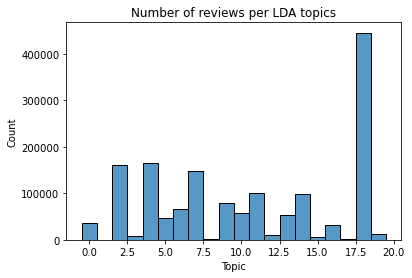

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data = topic_df, x = "Topic", discrete=True)
plt.title('Number of reviews per LDA topics')
plt.show()

### Let's regroup a few topics and focus on key criteria
- We remove 50% of the topics which are not focused / clear enough
- We gather the rest into 6 main criteria: Location, Rooms, Food & Breakfast, Families, Service, Sleep

In [190]:
topic_df = topic_df.loc[topic_df["Topic"].isin([7, 18, 0, 12, 15, 11, 5, 3, 6, 16])]
topic_df.loc[:,"Topic"] = topic_df.loc[:,"Topic"].replace({7:"Location", 18:"Location", 0:"Families", 12:"Food", 15:"Food", 11:"Sleep", 5:"Service", 3:"Rooms", 6:"Rooms", 16:"Rooms"})   # 10:"Service", 14:"Service"
print(topic_df)

           Index  Class     Topic
1              1      5     Rooms
3              3      5  Location
4              4      4     Rooms
5              5      3  Location
9              9      5  Location
...          ...    ...       ...
1534550  1534550      4  Location
1534551  1534551      5  Location
1534555  1534555      5  Location
1534557  1534557      5  Families
1534559  1534559      5  Location

[900375 rows x 3 columns]


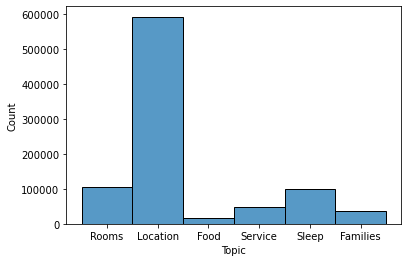

In [191]:
sns.histplot(data = topic_df, x = "Topic")
plt.show()

## Which criteria is the most important for the rating ?

In [192]:
rows = []
for rating, rating_df in topic_df.groupby("Class"):
    freq = ct.frequencies(rating_df.loc[:,"Topic"])
    freq["Rating"] = rating
    rows.append(freq)
    
freq_df = pd.DataFrame.from_dict(rows)
freq_df.set_index("Rating", drop = True, inplace = True) 
print(freq_df)

        Sleep  Food    Rooms  Location  Service  Families
Rating                                                   
0           2     1      NaN       NaN      NaN       NaN
1       14290  1026  33064.0    3639.0   2113.0     413.0
2       22058  1628  21493.0   13659.0   5490.0    1136.0
3       29415  3323  17122.0   68838.0  11830.0    3333.0
4       24881  5872  17635.0  248081.0  16851.0   12307.0
5        9051  5629  17086.0  259237.0  10611.0   19261.0


<AxesSubplot:xlabel='Rating'>

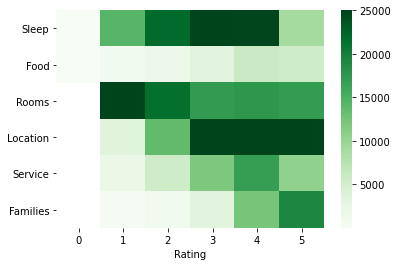

In [193]:
sns.heatmap(freq_df.T, vmax = 25000, cbar = True, cmap = "Greens")

### Conclusion
- The quality of the room / accomodation is the most important driver for bad reviews => Bad hotels are defined by their rooms.
- the location of the hotel is the most important driver for good reviews => Great hotels are defined by their location